In [1]:
#meta 4/14/2021 How to read a markup file and tranform it into a dataframe
#NLP, LSHTC (large scale hierarchical text classification)
#src data http://lshtc.iit.demokritos.gr/ LSHTC3
#src code based on https://github.com/Arf4t/Lshtc3_fasttext/blob/master/LSHTC3.ipynb

#input: sample.txt markup file
#output: df.pkl with documents and labels

#based on helloPy/myReadFile_Markup.ipynb
#4/5/2021 READ MARKUP FILE
#      OOP class read markup file

#history
#4/14/2021 READ MARKUP FILE AND RETURN TIDY DF
#      Explore labels
#      Prep data - df, one label per df row

#4/20/2021 [OPTIONAL] TIDY DF WITH LESS LABELS, REINDEXED
#      pandas df.explode lists to rows, ignore index - requires pandas 1.1.0+
#      N_LOW_COUNT = 1 (or some small number), 500 here - so full dataset

#4/21/2021 DF FINAL - DOCNO, TEXT and MULTI-LABELS
#      Encode target - multi-labels per document

In [2]:
import time as time #to track performance time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (10,6)

from bs4 import BeautifulSoup
from scipy import stats
from sklearn.preprocessing import OneHotEncoder

from joblib import load, dump

In [3]:
#global vars
TRAIN_FILE = 'data/LSHTCv3_sample_wikipediaMediumOriginal-train.txt'
DOC_LABEL = 13402
N_LOW_COUNT = 500
N_BINS = 25

In [4]:
#define a class to read a markup file and extract its elements
class myTextReader:
    """
    docstring for myTextReader
    read a markup file and return index, text, and labels
    input: specifically formattted file, i.e. LSHTCv3 markup text file
    output: lists of docs index, text, and labels
    """
    def __init__(self, file_path):
        self.file_path = file_path
        self.docno=[]
        self.labels=[]                      #parsing the required data about labels and documents
        self.data=[]
        
        soup=BeautifulSoup(open(self.file_path,'r',encoding='utf8'),'html.parser')
        
        for x in list(soup.find_all('docno')):
            self.docno.append(x.get_text())

        for x in list(soup.find_all('labels')):
            self.labels.append([ int(lab) for lab in x.get_text().split()])
            self.data.append(x.next_sibling.strip('\n'))

# LSHTC3

## 0.  Load Train Data
Read a Markup File - input and multiple labels

507 documents -> 1418 exploded documents  
1418 transformed labels -> 981 unique labels

Final ds shape:  
507 docs x 981 unique labels

In [5]:
#track time
t0 = time.time()

#read file
train_data = myTextReader(TRAIN_FILE) #class __main__.myTextReader

#display a couple of entities
train_data.docno[1:3], train_data.labels[1:3], train_data.data[1:3]

print("Processing time (in minutes): ", (time.time() - t0)/60)

Processing time (in minutes):  0.0015819589296976724


In [6]:
#explore text - number of documents
train_data.docno[-1], train_data.labels[-1], train_data.data[-1]

('507',
 [358040],
 'The Federal Bureau of Investigation\'s Most Wanted Terrorists is a list of fugitives who have been indicted by sitting Federal grand juries in the United States district courts, for alleged crimes of terrorism. The initial list was formed in late 2001 in the immediate aftermath of the 9/11 attacks and contained the names of 22 terrorists. It was the second major \\"wanted\\" list following the FBI\'s Ten Most Wanted Fugitives list. It now serves as a companion to that earlier list, which in years past, had listed several major terrorist fugitives.')

### 0.1 EDA

#### Explore Labels
Flatten labels - convert a nD list into a 1D list by un-nesting each list item stored in the list of lists

> Note: run into a nb limitation.  To change this limit, set the config variable `--NotebookApp.iopub_data_rate_limit`.  
jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10

In [7]:
#flatten labels
labels_list = [item for sublist in train_data.labels for item in sublist]
print('Transformed list preview: ', labels_list[:25])
print('Transformed list count: ', len(labels_list))

Transformed list preview:  [33692, 13402, 393382, 130762, 352578, 395447, 27512, 157031, 390846, 395447, 276114, 14661, 71999, 292915, 188756, 131368, 106615, 228092, 420589, 228506, 307963, 207086, 119558, 159586, 188582]
Transformed list count:  1418


In [8]:
#unique labels with counts
#src https://numpy.org/doc/stable/reference/generated/numpy.unique.html
labels_unique, labels_indices, labels_counts = np.unique(np.array(labels_list), return_inverse=True, return_counts = True)
print(labels_unique[:10], labels_counts[:10]) 
#print(labels_unique[-10:], labels_counts[-10:])
print(labels_indices[:10], labels_unique[labels_indices[:10]])

labels_unique.shape, labels_unique.max(), labels_counts.max()

[ 369  677  684 1087 1375 1640 2374 2549 2912 3403] [1 1 3 1 1 1 1 1 1 1]
[ 87  36 863 293 775 866  74 343 858 866] [ 33692  13402 393382 130762 352578 395447  27512 157031 390846 395447]


((981,), 444296, 19)

Confirmed count of labels

In [9]:
stats.describe(labels_counts)

DescribeResult(nobs=981, minmax=(1, 19), mean=1.4454638124362895, variance=1.673808483638104, skewness=5.762150330971793, kurtosis=50.227742461522276)

In [10]:
labels_counts.min(), labels_counts.mean(), np.median(labels_counts), labels_counts.max()

(1, 1.4454638124362895, 1.0, 19)

#### Explore Labels Visually

(array([777, 114,  38,   0,  23,  12,   5,   0,   4,   1,   0,   1,   3,
         1,   0,   1,   0,   0,   0,   0,   0,   0,   0,   0,   1],
      dtype=int64), array([ 1.  ,  1.72,  2.44,  3.16,  3.88,  4.6 ,  5.32,  6.04,  6.76,
        7.48,  8.2 ,  8.92,  9.64, 10.36, 11.08, 11.8 , 12.52, 13.24,
       13.96, 14.68, 15.4 , 16.12, 16.84, 17.56, 18.28, 19.  ]))


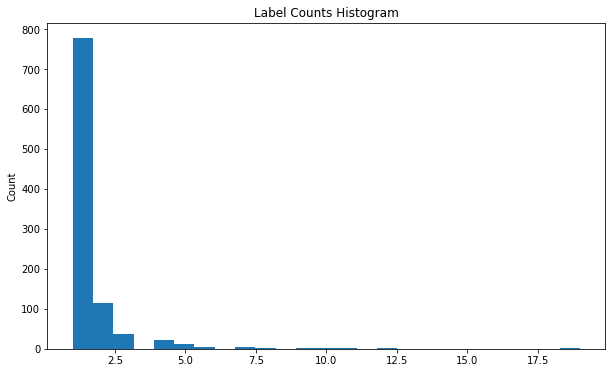

In [11]:
#visualize labels shape - so many ones
print(np.histogram(labels_counts, bins = N_BINS))
plt.hist(labels_counts, bins = N_BINS)
plt.title("Label Counts Histogram")
plt.ylabel("Count")
plt.show()

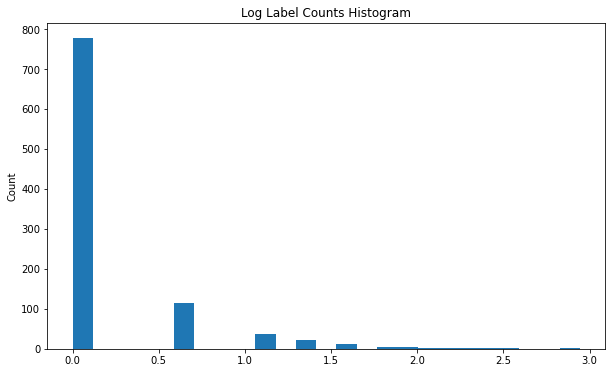

In [12]:
#visualize labels shape
plt.hist(np.log(labels_counts), bins = N_BINS)
plt.title("Log Label Counts Histogram")
plt.ylabel("Count")
plt.show()

#### Explore a Specific Label
How many labels 13402? Label 13402 indices

In [13]:
print(labels_list.count(DOC_LABEL))

#first index with label 1?
labels_list.index(DOC_LABEL)

#all indices with label 1
np.where(labels_indices == 0)[0]
#labels_list[104236]


3


array([247], dtype=int64)

#### Explore Labels with Low Count
How many labels with count 1? Count 1 indices, count 1 labels

In [14]:
print(labels_counts.tolist().count(1))
#all indices with label count=1, all labels with count=1
np.where(labels_counts == 1)[0], labels_unique[np.where(labels_counts == 1)[0]]

777


(array([  0,   1,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  14,
         15,  16,  17,  18,  20,  21,  22,  23,  25,  26,  27,  28,  30,
         31,  34,  35,  37,  39,  40,  41,  42,  43,  44,  46,  47,  48,
         49,  51,  52,  53,  54,  55,  56,  57,  58,  60,  61,  62,  63,
         64,  65,  66,  67,  69,  70,  72,  73,  75,  76,  78,  79,  80,
         81,  83,  84,  85,  86,  88,  89,  90,  91,  93,  94,  95,  96,
         97,  98,  99, 100, 102, 103, 105, 106, 107, 108, 109, 110, 111,
        112, 113, 114, 115, 116, 117, 119, 121, 122, 123, 125, 126, 128,
        129, 130, 131, 132, 133, 135, 136, 137, 138, 139, 140, 141, 143,
        145, 146, 147, 148, 149, 150, 151, 152, 154, 155, 158, 160, 161,
        162, 163, 164, 165, 166, 167, 169, 170, 171, 172, 174, 175, 177,
        178, 180, 181, 182, 183, 184, 185, 188, 190, 191, 192, 193, 195,
        196, 197, 198, 200, 201, 202, 204, 205, 206, 208, 209, 211, 212,
        213, 214, 216, 217, 218, 220, 221, 222, 224

Consider rolling up one level

#### Explore Most frequent Labels (with Highest Count)

In [15]:
#most frequent labels counts
print((sorted(labels_counts))[-10:])

#which label most frequent?
idx_label_most_frequent, = np.where(labels_counts == 11400) #tuple
label_most_frequent = labels_unique[idx_label_most_frequent]
idx_label_most_frequent, label_most_frequent

[7, 7, 8, 9, 10, 10, 10, 11, 12, 19]


(array([], dtype=int64), array([], dtype=int32))

## 1. Prep Data 

In [16]:
#make a dataframe with 'docno', 'labels', and 'text'
df = pd.DataFrame([train_data.docno, train_data.labels, train_data.data]).T
df.columns = ['docno', 'labels', 'text']
#df.set_index('docno', inplace=True)
print(df.shape)
print(df.dtypes)
df.head()

(507, 3)
docno     object
labels    object
text      object
dtype: object


,docno,labels,text
0,1,"[33692, 13402, 393382]",Alabama /\u02CC\u00E6l\u0259\u02C8b\u00E6m\u02...
1,2,[130762],Alain Connes (born 1 April 1947) is a French m...
2,3,"[352578, 395447, 27512, 157031]",Ayn Rand (born Alisa Zinov'yevna Rosenbaum; Fe...
3,4,"[390846, 395447, 276114]","Allan Dwan (April 3, 1885 – December 28, 1981)..."
4,5,"[14661, 71999, 292915, 188756, 131368]","Andre Kirk Agassi (born April 29, 1970) is an ..."


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 507 entries, 0 to 506
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   docno   507 non-null    object
 1   labels  507 non-null    object
 2   text    507 non-null    object
dtypes: object(3)
memory usage: 12.0+ KB


### 1.1 Explode list - one label per df row
Exploded lists to rows of the subset columns; index will be duplicated for these rows  
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.explode.html

In [18]:
#explode lists to rows, keep index
#df_tidy = df.explode('labels')

#explode lists to rows, ignore index - requires pandas 1.1.0+
df_tidy = df.explode('labels', ignore_index=True)
print(df_tidy.shape)
df_tidy.head(10)

(1418, 3)


,docno,labels,text
0,1,33692,Alabama /\u02CC\u00E6l\u0259\u02C8b\u00E6m\u02...
1,1,13402,Alabama /\u02CC\u00E6l\u0259\u02C8b\u00E6m\u02...
2,1,393382,Alabama /\u02CC\u00E6l\u0259\u02C8b\u00E6m\u02...
3,2,130762,Alain Connes (born 1 April 1947) is a French m...
4,3,352578,Ayn Rand (born Alisa Zinov'yevna Rosenbaum; Fe...
5,3,395447,Ayn Rand (born Alisa Zinov'yevna Rosenbaum; Fe...
6,3,27512,Ayn Rand (born Alisa Zinov'yevna Rosenbaum; Fe...
7,3,157031,Ayn Rand (born Alisa Zinov'yevna Rosenbaum; Fe...
8,4,390846,"Allan Dwan (April 3, 1885 – December 28, 1981)..."
9,4,395447,"Allan Dwan (April 3, 1885 – December 28, 1981)..."


#### Remove low count labels

In [19]:
#repeat from above
print(labels_counts.tolist().count(1))
#all indices with label count=1, all labels with count=1
np.where(labels_counts == N_LOW_COUNT)[0], labels_unique[np.where(labels_counts == N_LOW_COUNT)[0]]

777


(array([], dtype=int64), array([], dtype=int32))

In [20]:
#ie. in full train ds - know that labels 19, 445729 only happened once, in sample it's label 369, 444296
labels_list.count(369), labels_list.count(444296)

(1, 1)

In [21]:
labels_low_count = labels_unique[np.where(labels_counts == N_LOW_COUNT)[0]]
labels_low_count

array([], dtype=int32)

In [22]:
#confirm (manually) counts match before and after  
df_tidy = df_tidy[~df_tidy['labels'].isin(labels_low_count)]
print(df_tidy.shape)
df_tidy.head(10)

(1418, 3)


,docno,labels,text
0,1,33692,Alabama /\u02CC\u00E6l\u0259\u02C8b\u00E6m\u02...
1,1,13402,Alabama /\u02CC\u00E6l\u0259\u02C8b\u00E6m\u02...
2,1,393382,Alabama /\u02CC\u00E6l\u0259\u02C8b\u00E6m\u02...
3,2,130762,Alain Connes (born 1 April 1947) is a French m...
4,3,352578,Ayn Rand (born Alisa Zinov'yevna Rosenbaum; Fe...
5,3,395447,Ayn Rand (born Alisa Zinov'yevna Rosenbaum; Fe...
6,3,27512,Ayn Rand (born Alisa Zinov'yevna Rosenbaum; Fe...
7,3,157031,Ayn Rand (born Alisa Zinov'yevna Rosenbaum; Fe...
8,4,390846,"Allan Dwan (April 3, 1885 – December 28, 1981)..."
9,4,395447,"Allan Dwan (April 3, 1885 – December 28, 1981)..."


In [23]:
#confirm that removed label 393382 had only 1 count
labels_list.count(393382)

1

In [24]:
#save df
dump(df_tidy, 'output/LSHTCv3_sample_df.pkl')

['output/LSHTCv3_sample_df.pkl']

### 1.2 Encode target - multi-labels per document

Given a dataset with two features, we let the encoder find the unique values per feature and transform the data to a binary one-hot encoding.  
https://stackabuse.com/one-hot-encoding-in-python-with-pandas-and-scikit-learn/

In [25]:
ohe = pd.get_dummies(df_tidy['labels'], prefix='label')
print(ohe.shape)
ohe.head()

(1418, 981)


,label_369,label_677,label_684,label_1087,label_1375,label_1640,label_2374,label_2549,label_2912,label_3403,...,label_441100,label_441670,label_442888,label_443038,label_443106,label_443549,label_443820,label_444058,label_444110,label_444296
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [26]:
#add ohe labels to df_tidy
df_final = pd.concat([df_tidy, ohe], axis=1)
print(df_final.shape)
df_final.head()

(1418, 984)


,docno,labels,text,label_369,label_677,label_684,label_1087,label_1375,label_1640,label_2374,...,label_441100,label_441670,label_442888,label_443038,label_443106,label_443549,label_443820,label_444058,label_444110,label_444296
0,1,33692,Alabama /\u02CC\u00E6l\u0259\u02C8b\u00E6m\u02...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,13402,Alabama /\u02CC\u00E6l\u0259\u02C8b\u00E6m\u02...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,393382,Alabama /\u02CC\u00E6l\u0259\u02C8b\u00E6m\u02...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2,130762,Alain Connes (born 1 April 1947) is a French m...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3,352578,Ayn Rand (born Alisa Zinov'yevna Rosenbaum; Fe...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Get to matrix shape:  
507 docs x 981 unique labels

In [34]:
df_y = df_final.groupby('docno').sum()
print(df_y.shape)
df_y.head()

(507, 981)


,label_369,label_677,label_684,label_1087,label_1375,label_1640,label_2374,label_2549,label_2912,label_3403,...,label_441100,label_441670,label_442888,label_443038,label_443106,label_443549,label_443820,label_444058,label_444110,label_444296
docno,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
101,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
102,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Combine X&y:  
507 docs x 981 unique labels + original `labels` and `text` fields

In [31]:
df.set_index('docno', inplace=True)
print(df.shape)
df.head()

(507, 2)


,labels,text
docno,,
1,"[33692, 13402, 393382]",Alabama /\u02CC\u00E6l\u0259\u02C8b\u00E6m\u02...
2,[130762],Alain Connes (born 1 April 1947) is a French m...
3,"[352578, 395447, 27512, 157031]",Ayn Rand (born Alisa Zinov'yevna Rosenbaum; Fe...
4,"[390846, 395447, 276114]","Allan Dwan (April 3, 1885 – December 28, 1981)..."
5,"[14661, 71999, 292915, 188756, 131368]","Andre Kirk Agassi (born April 29, 1970) is an ..."


In [36]:
df_final = pd.merge(df, df_y, how='inner', left_index=True, right_index=True)
print(df_final.shape)
df_final.head()

(507, 983)


,labels,text,label_369,label_677,label_684,label_1087,label_1375,label_1640,label_2374,label_2549,...,label_441100,label_441670,label_442888,label_443038,label_443106,label_443549,label_443820,label_444058,label_444110,label_444296
docno,,,,,,,,,,,,,,,,,,,,,
1,"[33692, 13402, 393382]",Alabama /\u02CC\u00E6l\u0259\u02C8b\u00E6m\u02...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,[130762],Alain Connes (born 1 April 1947) is a French m...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"[352578, 395447, 27512, 157031]",Ayn Rand (born Alisa Zinov'yevna Rosenbaum; Fe...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,"[390846, 395447, 276114]","Allan Dwan (April 3, 1885 – December 28, 1981)...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,"[14661, 71999, 292915, 188756, 131368]","Andre Kirk Agassi (born April 29, 1970) is an ...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [45]:
#verify right labels for 1st doc
print(df.loc['1'])
df_final.loc['1'][['text', 'label_369','label_33692', 'label_13402','label_393382']]

labels                               [33692, 13402, 393382]
text      Alabama /\u02CC\u00E6l\u0259\u02C8b\u00E6m\u02...
Name: 1, dtype: object


text            Alabama /\u02CC\u00E6l\u0259\u02C8b\u00E6m\u02...
label_369                                                       0
label_33692                                                     1
label_13402                                                     1
label_393382                                                    1
Name: 1, dtype: object

In [46]:
#save df
dump(df_final, 'output/LSHTCv3_sample_df_multilabel.pkl')

['output/LSHTCv3_sample_df_multilabel.pkl']

In [29]:
mystop

NameError: name 'mystop' is not defined

In [ ]:
mystop

## Xtra

In [ ]:
#$acxtra manually, replicate Class - read an html file
tiny_docno=[]
tiny_labels=[]                      #parsing the required data about labels and documents
tiny_data=[]
        
soup=BeautifulSoup(open('input/wikipediaMediumOriginalLSHTCv3-train_tiny.txt','r',encoding='utf8'),'html.parser')

for x in list(soup.find_all('docno')):
    tiny_docno.append([ int(lab) for lab in x.get_text().split()])

for x in list(soup.find_all('labels')):
    tiny_labels.append([ int(lab) for lab in x.get_text().split()])
    tiny_data.append(x.next_sibling.strip('\n'))
    
#results after reading file
tiny_docno[1:3], tiny_labels[1:3], tiny_data[1:3]

In [ ]:
#$acxtra flatten list of lists example
#src https://stackabuse.com/python-how-to-flatten-list-of-lists/
#may run into nb limiation -  To change this limit, set the config variable `--NotebookApp.iopub_data_rate_limit`.  
#jupyter notebook --NotebookApp.iopub_data_rate_limit=1.0e10

regular_list = [[1, 2, 3, 4], [5, 6, 7], [8, 9]]
flat_list = [item for sublist in regular_list for item in sublist]
print('Original list', regular_list)
print('Transformed list', flat_list)

In [ ]:
#$acxtra find indices in array of values (not used here)
#Create a numpy array from a list of numbers
print([[11, 19, 18], [14, 15, 11], [19, 21, 46], [29, 21, 19]].__class__)
arr = np.array([[11, 19, 18], [14, 15, 11], [19, 21, 46], [29, 21, 19]])
print(arr)

result = np.where(arr == 19)
print(result)

listOfIndices= list(zip(result[0], result[1]))

for indice in listOfIndices:
    print(indice)

In [ ]:
#index of where most frequent label $acrevisit
idx2_label_most_frequent = []
for idx_most in train_data.labels:
    if label_most_frequent in idx_most:
        idx2_label_most_frequent.append(idx_most)

#confirm counts       
print(len(idx2_label_most_frequent))
#preview
idx2_label_most_frequent[:5]

In [ ]:
from sklearn.preprocessing import OneHotEncoder
x = [[11, "Spain"], [22, "France"], [33, "Spain"], [44, "Germany"], [55, "France"]]
y = OneHotEncoder().fit_transform(x).toarray()
print(y)

In [ ]:
x